<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/9%EC%A3%BC%EC%B0%A8/Alcohol_Sales_window_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------
# 1. 데이터 로드
# ------------------------------------
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1, 1)

In [18]:
# ------------------------------------
# 2. 정규화
# ------------------------------------
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [19]:
# ------------------------------------
# 3. 시퀀스 생성 (window=12로 증가)
# ------------------------------------
window = 12
X, y = [], []
for i in range(len(data) - window):
    X.append(data[i:i+window])
    y.append(data[i+window])
X, y = np.array(X), np.array(y)

In [20]:
# ------------------------------------
# 4. Train/Test 분할 (시계열이므로 shuffle X)
# ------------------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
# ------------------------------------
# 5. 첫 번째 모델 (RNN)
# ------------------------------------
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='tanh', input_shape=(window, 1)),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# ------------------------------------
# 6. Bidirectional LSTM 모델 정의
# ------------------------------------
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=(window, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1)
])

model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# ------------------------------------
# 7. 학습 (EarlyStopping 적용)
# ------------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

history = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0056 - val_loss: 0.0145
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0079
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6991e-04 - val_loss: 0.0032
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 0.0144
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0107
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8741e-04 - val_loss: 0.0038
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

In [26]:
# ------------------------------------
# 8. 테스트 데이터 예측
# ------------------------------------
pred_rnn = model_rnn.predict(X_test)
pred_lstm = model_lstm.predict(X_test)

# 앙상블 (단순 평균)
final_pred = (pred_rnn + pred_lstm) / 2

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [27]:
# ------------------------------------
# 9. 역정규화 및 평가
# ------------------------------------
true_vals = scaler.inverse_transform(y_test)
pred_avg = scaler.inverse_transform(final_pred)

mse = mean_squared_error(true_vals, pred_avg)
r2 = r2_score(true_vals, pred_avg)
print(f"\n RNN + LSTM Ensemble 결과")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


 RNN + LSTM Ensemble 결과
MSE: 508100.2162
R² Score: 0.8110


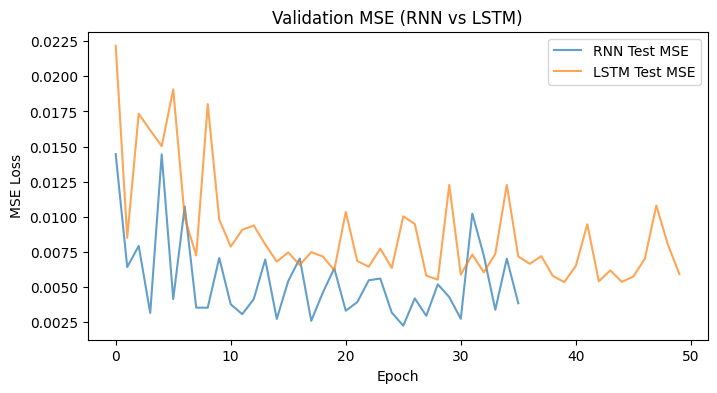

In [28]:
# ------------------------------------
# 10. MSE 손실 시각화
# ------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['val_loss'], label='RNN Test MSE', alpha=0.7)
plt.plot(history_lstm.history['val_loss'], label='LSTM Test MSE', alpha=0.7)
plt.title('Validation MSE (RNN vs LSTM)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

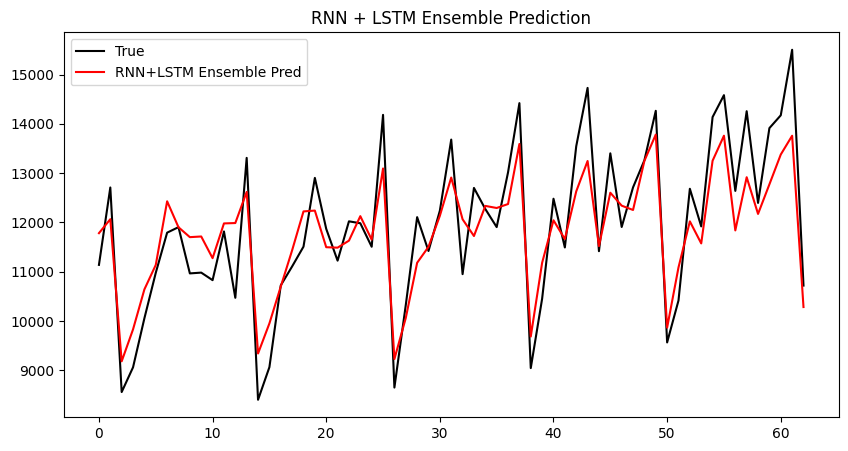

In [29]:
# ------------------------------------
# 11. 실제값 vs 예측값 시각화
# ------------------------------------
plt.figure(figsize=(10,5))
plt.plot(true_vals, label='True', color='black')
plt.plot(pred_avg, label='RNN+LSTM Ensemble Pred', color='red')
plt.title('RNN + LSTM Ensemble Prediction')
plt.legend()
plt.show()